# Configuration de Cuda dans Google Colab

In [17]:
!nvcc -V  

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0


In [18]:
!pip install git+https://github.com/andreinechaev/nvcc4jupyter.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/andreinechaev/nvcc4jupyter.git to /tmp/pip-req-build-wh3ysa0q
  Running command git clone --filter=blob:none --quiet https://github.com/andreinechaev/nvcc4jupyter.git /tmp/pip-req-build-wh3ysa0q
  Resolved https://github.com/andreinechaev/nvcc4jupyter.git to commit aac710a35f52bb78ab34d2e52517237941399eff
  Preparing metadata (setup.py) ... done


## On vérifie que l'on est bien connecté au GPU

In [19]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Apr  4 21:38:45 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Chargement du plugin nvcc permettant de compiler/executer les programmes Cuda

In [20]:
%load_ext nvcc_plugin

The nvcc_plugin extension is already loaded. To reload it, use:
  %reload_ext nvcc_plugin


## Un makefile est déjà à votre disposition pour compiler les programme du TP


### 1. Executez la cellule du Makefile

Le makefile a été modifié pour les programmes puisse s'exécuter avec la GPU premium.



In [21]:
%%writefile Makefile
# Change the example variable to build a different source module (e.g. EXAMPLE=exercice01)
EXAMPLE=program

# Makefile variables 
# Add extra targets to OBJ with space separator e.g. If there is as source file random.c then add random.o to OBJ)
# Add any additional dependancies (header files) to DEPS. e.g. if there is aheader file random.h required by your source modules then add this to DEPS.
CC=gcc
CFLAGS= -O3 -Wextra -fopenmp
NVCC=nvcc
NVCC_FLAGS= -gencode arch=compute_75,code=sm_75 -gencode arch=compute_80,code=sm_80 -gencode arch=compute_86,code=sm_86 -gencode arch=compute_87,code=sm_87
OBJ=$(EXAMPLE).o
DEPS=

# Build rule for object files ($@ is left hand side of rule, $< is first item from the right hand side of rule)
%.o : %.cu $(DEPS)
	$(NVCC) -c -o $@ $< $(NVCC_FLAGS) $(addprefix -Xcompiler ,$(CCFLAGS))

# Make example ($^ is all items from right hand side of the rule)
$(EXAMPLE) : $(OBJ)
	$(NVCC) -o $@ $^ $(NVCC_FLAGS) $(addprefix -Xcompiler ,$(CCFLAGS))

# PHONY prevents make from doing something with a filename called clean
.PHONY : clean
clean:
	rm -rf $(EXAMPLE) $(OBJ)

Overwriting Makefile


# TP6



In [22]:
%%writefile utils.h
#ifndef __UTILS_H__
#define __UTILS_H__
#include <stdio.h>

static void HandleError( cudaError_t err,
                         const char *file,
                         int line ) {
    if (err != cudaSuccess) {
        printf( "%s in %s at line %d\n", cudaGetErrorString( err ),
                file, line );
        exit( EXIT_FAILURE );
    }
}
#define HANDLE_ERROR( err ) (HandleError( err, __FILE__, __LINE__ ))


#define HANDLE_NULL( a ) {if (a == NULL) { \
                            printf( "Host memory failed in %s at line %d\n", \
                                    __FILE__, __LINE__ ); \
                            exit( EXIT_FAILURE );}}

template< typename T >
void swap( T& a, T& b ) {
    T t = a;
    a = b;
    b = t;
}


void* big_random_block( int size ) {
    unsigned char *data = (unsigned char*)malloc( size );
    HANDLE_NULL( data );
    for (int i=0; i<size; i++)
        data[i] = rand();

    return data;
}

int* big_random_block_int( int size ) {
    int *data = (int*)malloc( size * sizeof(int) );
    HANDLE_NULL( data );
    for (int i=0; i<size; i++)
        data[i] = rand();

    return data;
}


// a place for common kernels - starts here

__device__ unsigned char value( float n1, float n2, int hue ) {
    if (hue > 360)      hue -= 360;
    else if (hue < 0)   hue += 360;

    if (hue < 60)
        return (unsigned char)(255 * (n1 + (n2-n1)*hue/60));
    if (hue < 180)
        return (unsigned char)(255 * n2);
    if (hue < 240)
        return (unsigned char)(255 * (n1 + (n2-n1)*(240-hue)/60));
    return (unsigned char)(255 * n1);
}

__global__ void float_to_color( unsigned char *optr,
                              const float *outSrc ) {
    // map from threadIdx/BlockIdx to pixel position
    int x = threadIdx.x + blockIdx.x * blockDim.x;
    int y = threadIdx.y + blockIdx.y * blockDim.y;
    int offset = x + y * blockDim.x * gridDim.x;

    float l = outSrc[offset];
    float s = 1;
    int h = (180 + (int)(360.0f * outSrc[offset])) % 360;
    float m1, m2;

    if (l <= 0.5f)
        m2 = l * (1 + s);
    else
        m2 = l + s - l * s;
    m1 = 2 * l - m2;

    optr[offset*4 + 0] = value( m1, m2, h+120 );
    optr[offset*4 + 1] = value( m1, m2, h );
    optr[offset*4 + 2] = value( m1, m2, h -120 );
    optr[offset*4 + 3] = 255;
}

__global__ void float_to_color( uchar4 *optr,
                              const float *outSrc ) {
    // map from threadIdx/BlockIdx to pixel position
    int x = threadIdx.x + blockIdx.x * blockDim.x;
    int y = threadIdx.y + blockIdx.y * blockDim.y;
    int offset = x + y * blockDim.x * gridDim.x;

    float l = outSrc[offset];
    float s = 1;
    int h = (180 + (int)(360.0f * outSrc[offset])) % 360;
    float m1, m2;

    if (l <= 0.5f)
        m2 = l * (1 + s);
    else
        m2 = l + s - l * s;
    m1 = 2 * l - m2;

    optr[offset].x = value( m1, m2, h+120 );
    optr[offset].y = value( m1, m2, h );
    optr[offset].z = value( m1, m2, h -120 );
    optr[offset].w = 255;
}


#if _WIN32
    //Windows threads.
    #include <windows.h>

    typedef HANDLE CUTThread;
    typedef unsigned (WINAPI *CUT_THREADROUTINE)(void *);

    #define CUT_THREADPROC unsigned WINAPI
    #define  CUT_THREADEND return 0

#else
    //POSIX threads.
    #include <pthread.h>

    typedef pthread_t CUTThread;
    typedef void *(*CUT_THREADROUTINE)(void *);

    #define CUT_THREADPROC void
    #define  CUT_THREADEND
#endif

//Create thread.
CUTThread start_thread( CUT_THREADROUTINE, void *data );

//Wait for thread to finish.
void end_thread( CUTThread thread );

//Destroy thread.
void destroy_thread( CUTThread thread );

//Wait for multiple threads.
void wait_for_threads( const CUTThread *threads, int num );

#if _WIN32
    //Create thread
    CUTThread start_thread(CUT_THREADROUTINE func, void *data){
        return CreateThread(NULL, 0, (LPTHREAD_START_ROUTINE)func, data, 0, NULL);
    }

    //Wait for thread to finish
    void end_thread(CUTThread thread){
        WaitForSingleObject(thread, INFINITE);
        CloseHandle(thread);
    }

    //Destroy thread
    void destroy_thread( CUTThread thread ){
        TerminateThread(thread, 0);
        CloseHandle(thread);
    }

    //Wait for multiple threads
    void wait_for_threads(const CUTThread * threads, int num){
        WaitForMultipleObjects(num, threads, true, INFINITE);

        for(int i = 0; i < num; i++)
            CloseHandle(threads[i]);
    }

#else
    //Create thread
    CUTThread start_thread(CUT_THREADROUTINE func, void * data){
        pthread_t thread;
        pthread_create(&thread, NULL, func, data);
        return thread;
    }

    //Wait for thread to finish
    void end_thread(CUTThread thread){
        pthread_join(thread, NULL);
    }

    //Destroy thread
    void destroy_thread( CUTThread thread ){
        pthread_cancel(thread);
    }

    //Wait for multiple threads
    void wait_for_threads(const CUTThread * threads, int num){
        for(int i = 0; i < num; i++)
            end_thread( threads[i] );
    }

#endif

#endif  // __UTILS_H__

Overwriting utils.h


## Programme permettant de connaitre les propriétés du GPU.

In [24]:
%%writefile program.cu
#include <stdio.h>
#include "utils.h"

int main(void){
  cudaDeviceProp prop;

  int count;
  HANDLE_ERROR(cudaGetDeviceCount(&count));

  for (int i=0; i< count; i++) {
    HANDLE_ERROR(cudaGetDeviceProperties(&prop, i));
    printf("Name: %s\n", prop.name);
    printf("Compute capability: %d.%d\n", prop.major, prop.minor);
    printf("Clock rate: %d\n", prop.clockRate);
    printf("Device copy overlap: ");
    if (prop.deviceOverlap)
      printf("Enabled\n");
    else
      printf("Disabled\n");
    printf("Kernel execution timeout : ");
    if (prop.kernelExecTimeoutEnabled)
      printf("Enabled\n");
    else
      printf("Disabled\n");

      printf(" --- Memory Information for device %d ---\n", i);
      printf("Total global mem: %ld\n", prop.totalGlobalMem);
      printf("Total constant mem: %ld\n", prop.totalConstMem);
      printf("Max mem pitch: %ld\n", prop.memPitch);
      printf("Texture Alignment: %ld\n", prop.textureAlignment);
      printf(
      "Maximum Texture Dimension Size (x,y,z)         1D=(%d), 2D=(%d, "
      "%d), 3D=(%d, %d, %d)\n",
      prop.maxTexture1D, prop.maxTexture2D[0],
      prop.maxTexture2D[1], prop.maxTexture3D[0],
      prop.maxTexture3D[1], prop.maxTexture3D[2]);
  printf(
      "Maximum Layered 1D Texture Size, (num) layers  1D=(%d), %d layers\n",
      prop.maxTexture1DLayered[0], prop.maxTexture1DLayered[1]);
  printf(
      "Maximum Layered 2D Texture Size, (num) layers  2D=(%d, %d), %d "
      "layers\n",
      prop.maxTexture2DLayered[0], prop.maxTexture2DLayered[1],
      prop.maxTexture2DLayered[2]);

      printf(" --- MP Information for device %d ---\n", i);
      printf("Warp size: %d\n",
           prop.warpSize);
      printf("multiprocessor count : %d\n", prop.multiProcessorCount);
      printf("shared mem per mp: %ld\n", prop.sharedMemPerBlock);
      printf("Registers per mp: %d\n", prop.regsPerBlock);
      printf("Threads in warp: %d\n", prop.warpSize);
      printf("Max threads per block: %d\n", prop.maxThreadsPerBlock);
      printf("Max thread dimensions: (%d, %d, %d)\n", prop.maxThreadsDim[0], prop.maxThreadsDim[1], prop.maxThreadsDim[2]);
      printf("Max grid dimensions: (%d, %d, %d)\n", prop.maxGridSize[0], prop.maxGridSize[1], prop.maxGridSize[2]);
      printf("\n");

  }
  return 0;
}

Overwriting program.cu


In [25]:
!make

nvcc -c -o program.o program.cu -gencode arch=compute_75,code=sm_75 -gencode arch=compute_80,code=sm_80 -gencode arch=compute_86,code=sm_86 -gencode arch=compute_87,code=sm_87 
nvcc -o program program.o -gencode arch=compute_75,code=sm_75 -gencode arch=compute_80,code=sm_80 -gencode arch=compute_86,code=sm_86 -gencode arch=compute_87,code=sm_87 


In [26]:
!./program

Name: Tesla T4
Compute capability: 7.5
Clock rate: 1590000
Device copy overlap: Enabled
Kernel execution timeout : Disabled
 --- Memory Information for device 0 ---
Total global mem: 15835398144
Total constant mem: 65536
Max mem pitch: 2147483647
Texture Alignment: 512
Maximum Texture Dimension Size (x,y,z)         1D=(131072), 2D=(131072, 65536), 3D=(16384, 16384, 16384)
Maximum Layered 1D Texture Size, (num) layers  1D=(32768), 2048 layers
Maximum Layered 2D Texture Size, (num) layers  2D=(32768, 32768), 2048 layers
 --- MP Information for device 0 ---
Warp size: 32
multiprocessor count : 40
shared mem per mp: 49152
Registers per mp: 65536
Threads in warp: 32
Max threads per block: 1024
Max thread dimensions: (1024, 1024, 64)
Max grid dimensions: (2147483647, 65535, 65535)



## 1. Ray Tracing et mémoire constante

Prenez du temps pour comprendre le code, executez le et lancez les commandes python qui suivent pour afficher l'image.

### Mémoire constante.

Modifiez le code afin de pouvoir effectuer un ray_tracing en utilisant la mémoire constante. Pour cela :
#### 1.1 Creer la variable c_s dans la mémoire constante en utilisant la structure Sphere. La variable contiendra un nombre de sphères égale à MAX_SPHERE.
#### 1.2 Ecrivez les instructions nécessaire dans le kernel **ray_trace_const** afin d'aller chercher les spheres dans la mémoire constante et non plus dans la mémoire globale.
#### 1.3 Copier le contenu de h_s dans c_s en utilisant la fonction **cudaMemcpyToSymbol**.
#### 1.4 Lancer le kernel.

Une fois les étapes effectuer, exécutez le code. Que constatez-vous ?
Remplissez le tableau de temps qui est sur github.

In [31]:
%%writefile program.cu
#include "cuda.h"
#include "utils.h"

#define IMAGE_DIM 1024

#define rnd( x ) (x * rand() / RAND_MAX)
#define INF     2e10f
#define MAX_SPHERES 20


void output_image_file(uchar4* image);

struct Sphere {
    float   r,b,g;
    float   radius;
    float   x,y,z;
    __device__ float sphere_intersect(float ox, float oy, float *n) {
      float dx = ox - x;
      float dy = oy - y;
      if (dx*dx + dy*dy < radius*radius) {
        float dz = sqrtf(radius*radius - dx*dx - dy*dy);
        *n = dz / sqrtf(radius * radius);
        return dz + z;
      }
      return -INF;
    }
};


__global__ void ray_trace(uchar4 *image, Sphere *d_s) {
    int x = threadIdx.x + blockIdx.x * blockDim.x;
    int y = threadIdx.y + blockIdx.y * blockDim.y;
    int offset = x + y * blockDim.x * gridDim.x;
    float   ox = (x - IMAGE_DIM / 2.0f);
    float   oy = (y - IMAGE_DIM / 2.0f);

    float   r = 0, g = 0, b = 0;
    float   maxz = -INF;
    for (int i = 0; i<MAX_SPHERES; i++) {
      Sphere *s = &d_s[i];
      float   n;
      float   t = s[i].sphere_intersect(ox, oy, &n);
      if (t > maxz) {
        float fscale = n;
        r = s->r * fscale;
        g = s->g * fscale;
        b = s->b * fscale;
        maxz = t;
      }
    }

    image[offset].x = (int)(r * 255);
    image[offset].y = (int)(g * 255);
    image[offset].z = (int)(b * 255);
    image[offset].w = 255;
}

// 1.1
__constant__ Sphere c_s[MAX_SPHERES];

// 1.2
__global__ void ray_trace_const(uchar4 *image) {
	int x = threadIdx.x + blockIdx.x * blockDim.x;
    int y = threadIdx.y + blockIdx.y * blockDim.y;
    int offset = x + y * blockDim.x * gridDim.x;
    float   ox = (x - IMAGE_DIM / 2.0f);
    float   oy = (y - IMAGE_DIM / 2.0f);

    float   r = 0, g = 0, b = 0;
    float   maxz = -INF;
    for (int i = 0; i<MAX_SPHERES; i++) {
      Sphere *s = &c_s[i];
      float   n;
      float   t = s[i].sphere_intersect(ox, oy, &n);
      if (t > maxz) {
        float fscale = n;
        r = s->r * fscale;
        g = s->g * fscale;
        b = s->b * fscale;
        maxz = t;
      }
    }

    image[offset].x = (int)(r * 255);
    image[offset].y = (int)(g * 255);
    image[offset].z = (int)(b * 255);
    image[offset].w = 255;
}



int main( void ) {
    unsigned int image_size, spheres_size;
    uchar4 *d_image; // Donnees sur GPU correspondant a l'image qui sera genere par le kernel
    uchar4 *h_image; // Donnes sur CPU correspondant a l'image qui sera genere par le kernel
    cudaEvent_t start, stop;
    Sphere h_s[MAX_SPHERES]; // Donnees des spheres sur GPU
    Sphere *d_s; // Donnees des spheres sur GPU
    float3 timing_data; //donnees pour le timing [0]=normal, [1]=const
    timing_data.x = 0.0;
    timing_data.y = 0.0;
    timing_data.z = 0.0;
    // taille de l'image en octets
    image_size = IMAGE_DIM*IMAGE_DIM*sizeof(uchar4);
    // taille des spheres en octets
    spheres_size = sizeof(Sphere)*MAX_SPHERES;

    // creation du timer
    cudaEventCreate(&start);
    cudaEventCreate(&stop);

    h_image = (uchar4*)malloc(image_size);
    
    // Allocation mémoire GPU
    cudaMalloc( (void**)&d_image, image_size);
    cudaMalloc( (void**)&d_s, spheres_size);

    // Creation random de spheres
    for (int i = 0; i<MAX_SPHERES; i++) {
      h_s[i].r = rnd(1.0f);
      h_s[i].g = rnd(1.0f);
      h_s[i].b = rnd(1.0f);
      h_s[i].x = rnd((float)IMAGE_DIM) - (IMAGE_DIM / 2.0f);
      h_s[i].y = rnd((float)IMAGE_DIM) - (IMAGE_DIM / 2.0f);
      h_s[i].z = rnd((float)IMAGE_DIM) - (IMAGE_DIM / 2.0f);
      h_s[i].radius = rnd(100.0f) + 20;
    }
    cudaMemcpy(d_s, h_s, spheres_size, cudaMemcpyHostToDevice);
    
    // 1.3
    cudaMemcpyToSymbol(c_s, d_s, spheres_size);


    // definition du nombre de thread par blocs et de bloc par grille
    dim3    blocksPerGrid(IMAGE_DIM / 16, IMAGE_DIM / 16);
    dim3    threadsPerBlock(16, 16);

    cudaEventRecord(start, 0);
    ray_trace << <blocksPerGrid, threadsPerBlock >> >(d_image, d_s);
    cudaEventRecord(stop, 0);
    cudaEventSynchronize(stop);
    cudaEventElapsedTime(&timing_data.x, start, stop);

    cudaEventRecord(start, 0);

    // 1.4
    ray_trace<<<blocksPerGrid,threadsPerBlock>>>(d_image, d_s);


	  cudaEventRecord(stop, 0);
  	cudaEventSynchronize(stop);
	  cudaEventElapsedTime(&timing_data.y, start, stop);

    cudaMemcpy(h_image, d_image, image_size, cudaMemcpyDeviceToHost);

    //Temps en sortie
    printf("Timing Data Table\n Spheres | Normal | Const\n");
    printf(" %-7i | %-6.3f | %.3f\n", MAX_SPHERES, timing_data.x, timing_data.y);

    // Image en sortie
    output_image_file(h_image);

    // On supprime les allocations memoire
    cudaEventDestroy(start);
    cudaEventDestroy(stop);
    cudaFree(d_image);
    cudaFree(d_s);
    free(h_image);

    return 0;

}

void output_image_file(uchar4* image)
{
	FILE *f; //Permet de contenir le fichier output.ppm

	//ouvre le fichier output.ppm et ecris des info en en-tete
	f = fopen("output_sphere.ppm", "wb");
	if (f == NULL){
		fprintf(stderr, "Error opening 'output_sphere.ppm' output file\n");
		exit(1);
	}
	fprintf(f, "P6\n");
	fprintf(f, "# Programmation GPU CUDA\n");
	fprintf(f, "%d %d\n%d\n", IMAGE_DIM, IMAGE_DIM, 255);
	for (int x = 0; x < IMAGE_DIM; x++){
		for (int y = 0; y < IMAGE_DIM; y++){
			int i = x + y*IMAGE_DIM;
			fwrite(&image[i], sizeof(unsigned char), 3, f); //only write rgb (ignoring a)
		}
	}
	
	fclose(f);
}


Overwriting program.cu


In [32]:
!make

nvcc -c -o program.o program.cu -gencode arch=compute_75,code=sm_75 -gencode arch=compute_80,code=sm_80 -gencode arch=compute_86,code=sm_86 -gencode arch=compute_87,code=sm_87 
nvcc -o program program.o -gencode arch=compute_75,code=sm_75 -gencode arch=compute_80,code=sm_80 -gencode arch=compute_86,code=sm_86 -gencode arch=compute_87,code=sm_87 


In [33]:
!./program

Timing Data Table
 Spheres | Normal | Const
 20      | 0.384  | 0.375


In [34]:
from PIL import Image

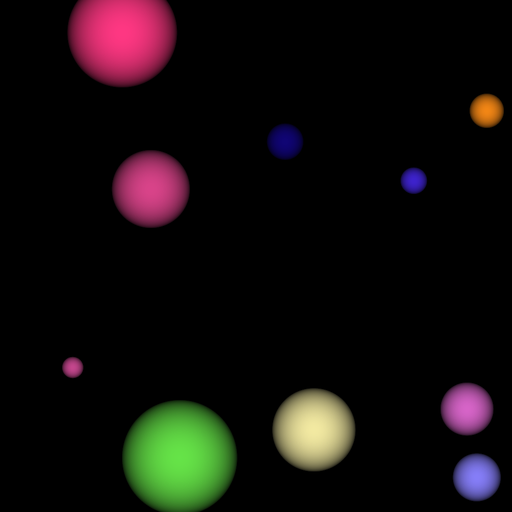

In [35]:
size = 512, 512
im = Image.open("./output_sphere.ppm")
im.thumbnail(size,Image.ANTIALIAS)
im

**Nous obtenons une image avec des sphères générés par ray tracing. En ce qui concerne les temps, ils sont relativements proches (0.381 contre 0.375) ce qui signifie que l'utilisation de la mémoire constante n'a pas améliorer les performances dans notre cas. Nous pensons que le nombre de sphères générés (seulement 20) est surement l'une des causes. **

## 2. Flou d'image et mémoire de texture

Le but de cet exercice est d'implementer, en utilisant les versions 1D et 2D de la mémoire de texture, un kernel qui, étant donné une image en entrée, nous renvoi l'image flouté. 

Dans le programme suivant : 
- **input_image_file(const char\* filename, uchar4* image)** vous permet de lire l'image input.ppm et de la charger en mémoire.
- **output_image_file(uchar4* image)** permet de sauvegarder l'image output.ppm sur disque
- Dans une image en couleur (RGB), chaque pixel contient 3 valeurs, une pour chaque channel R, G et B. Ces valeurs sont comprises entre 0 et 255. Pour cela nous utilisons le type **uchar4**.

#### uchar4
Un uchar4 est une structure de données qui représente un vecteur de quatre octets (8 bits chacun) non signés. Le préfixe "u" signifie "unsigned", ce qui indique que les valeurs stockées dans les octets sont supérieur à 0. 

```c 
typedef struct {
   unsigned char x, y, z, w;
} uchar4;
```

Ici nous nous intéréssons aux 3 premières valeurs x, y, z représentant les channel R(rouge), G(vert), B(bleu). w est laissé à 255.

Nous voulons stocker toute l'image sur la mémoire de texture du GPU en utilisons le type de structure uchar4. L'image input.ppm est de taille 2048x2048. La taille totale qu'il faudra allouer et donc de 2048x2048x4 = 16 777 216 bytes. Ce qui nous fait ~17Kb de mémoire. La Nvidia T4 (GPU standard) peut allouer jusqu'à 131 Kb de mémoire texture en 1D.

Avant de vous lancer, prenez un peu de temps pour comprendre ce que fait le kernel **image_blur** (venez me voir si vous ne comprenez pas), exécutez le code et regardez le résultat grâce aux fonctions pythons.

### Mémoire de texture 1D

Modifiez le code afin de pouvoir lancer le kernel **image_blur_texture1D** en utilisant la mémoire de texture 1D. Pour cela :
#### 2.1 Creer la variable Sample1D de type uchar4 avec la structure de données **texture**
#### 2.2 Modifier le kernel image_blur_texture1D, pour que les threads aillent chercher la valeur d'un pixel dans la mémoire de texture et non pas dans la mémoire partagée à l'aide de la fonction Cuda **tex1Dfetch**.
#### 2.3 Copier l'image dans la mémoire de texture via la fonction **cudaBindTexture**.
#### 2.4 Libéré la mémoire de texture
#### 2.5 Décommenter le lancement du kernel et les fonctiosn liées au timer.

Executez le code.

### Mémoire de texture 2D
Modifiez le code afin de pouvoir lancer le kernel **image_blur_texture1D** en utilisant la mémoire de texture 1D. Pour cela :
#### 2.6 Creer la variable Sample2D de type uchar4 avec la structure de données **texture**
#### 2.7 Modifier le kernel image_blur_texture2D, pour que les threads aillent chercher la valeur d'un pixel dans la mémoire de texture et non pas dans la mémoire partagée à l'aide de la fonction Cuda **tex2D**.
#### 2.8 Copier l'image dans la mémoire de texture via la fonction **cudaBindTexture**.
#### 2.9 Libéré la mémoire de texture
#### 2.10 Décommenter le lancement du kernel et les fonctions liées au timer.

Executez le code.

A votre avis, pourquoi les versions utilisant la mémoire de texture prennent plus de temps que celle utilisant la mémoire globale ?
Que constatez vous sur les temps d'execution des versions 1D et 2D.

In [36]:
%%writefile program.cu
#ifndef __CUDACC__
#define __CUDACC__
#endif
#pragma warning(disable : 4996)
#pragma nv_diag_suppress = deprecated_entity
#include "cuda_runtime.h"
#include "device_launch_parameters.h"
#include <stdio.h>
#include <stdlib.h>
#include <math.h>
#include <string.h>
#include <vector_types.h>
#include <vector_functions.h>

#include <cuda_texture_types.h>
#include <texture_fetch_functions.h>

#define IMAGE_DIM 2048
#define SAMPLE_SIZE 6
#define NUMBER_OF_SAMPLES (((SAMPLE_SIZE*2)+1)*((SAMPLE_SIZE*2)+1))

#define rnd( x ) (x * rand() / RAND_MAX)
#define INF     2e10f

void output_image_file(uchar4* image);
void input_image_file(const char* filename, uchar4* image);
void checkCUDAError(const char *msg);

// 2.1
texture<uchar4, cudaTextureType1D, cudaReadModeElementType> Sample1D;


// Ex 2.6


__global__ void image_blur(uchar4 *image, uchar4 *image_output) {
	// associe les threadIdx/BlockIdx au position des pixels.
	int x = threadIdx.x + blockIdx.x * blockDim.x;
	int y = threadIdx.y + blockIdx.y * blockDim.y;
	int output_offset = x + y * blockDim.x * gridDim.x;
	uchar4 pixel;
	float4 average = make_float4(0, 0, 0, 0);

	for (int i = -SAMPLE_SIZE; i <= SAMPLE_SIZE; i++){
		for (int j = -SAMPLE_SIZE; j <= SAMPLE_SIZE; j++){
			int x_offset = x + i;
			int y_offset = y + j;
			// On fait attention aux conditions de bords
			if (x_offset < 0)
				x_offset += IMAGE_DIM;
			if (x_offset >= IMAGE_DIM)
				x_offset -= IMAGE_DIM;
			if (y_offset < 0)
				y_offset += IMAGE_DIM;
			if (y_offset >= IMAGE_DIM)
				y_offset -= IMAGE_DIM;
			int offset = x_offset + y_offset * blockDim.x * gridDim.x;
			pixel = image[offset];

			// On somme les valeurs
			average.x += pixel.x;
			average.y += pixel.y;
			average.z += pixel.z;
		}
	}
	// On cacul la moyenne
	average.x /= (float)NUMBER_OF_SAMPLES;
	average.y /= (float)NUMBER_OF_SAMPLES;
	average.z /= (float)NUMBER_OF_SAMPLES;

	image_output[output_offset].x = (unsigned char)average.x;
	image_output[output_offset].y = (unsigned char)average.y;
	image_output[output_offset].z = (unsigned char)average.z;
	image_output[output_offset].w = 255;
}

// 2.2
__global__ void image_blur_texture1D(uchar4 *image_output) {
	// associe les threadIdx/BlockIdx au position des pixels.
	int x = threadIdx.x + blockIdx.x * blockDim.x;
	int y = threadIdx.y + blockIdx.y * blockDim.y;
	int output_offset = x + y * blockDim.x * gridDim.x;
	uchar4 pixel;
	float4 average = make_float4(0, 0, 0, 0);

	for (int i = -SAMPLE_SIZE; i <= SAMPLE_SIZE; i++){
		for (int j = -SAMPLE_SIZE; j <= SAMPLE_SIZE; j++){
			int x_offset = x + i;
			int y_offset = y + j;
			// On fait attention aux conditions de bords
			if (x_offset < 0)
				x_offset += IMAGE_DIM;
			if (x_offset >= IMAGE_DIM)
				x_offset -= IMAGE_DIM;
			if (y_offset < 0)
				y_offset += IMAGE_DIM;
			if (y_offset >= IMAGE_DIM)
				y_offset -= IMAGE_DIM;
			int offset = x_offset + y_offset * blockDim.x * gridDim.x;
			pixel = tex1Dfetch(Sample1D, x_offset + y_offset * blockDim.x * gridDim.x);
			//pixel = image[offset];

			// On somme les valeurs
			average.x += pixel.x;
			average.y += pixel.y;
			average.z += pixel.z;
		}
	}
	// On cacul la moyenne
	average.x /= (float)NUMBER_OF_SAMPLES;
	average.y /= (float)NUMBER_OF_SAMPLES;
	average.z /= (float)NUMBER_OF_SAMPLES;

	image_output[output_offset].x = (unsigned char)average.x;
	image_output[output_offset].y = (unsigned char)average.y;
	image_output[output_offset].z = (unsigned char)average.z;
	image_output[output_offset].w = 255;
}

// Ex 2.7
__global__ void image_blur_texture2D(uchar4 *image_output) {
	
  int x = threadIdx.x + blockIdx.x * blockDim.x;
	int y = threadIdx.y + blockIdx.y * blockDim.y;
	int output_offset = x + y * blockDim.x * gridDim.x;
	uchar4 pixel;
	float4 average = make_float4(0, 0, 0, 0);

	for (int i = -SAMPLE_SIZE; i <= SAMPLE_SIZE; i++){
		for (int j = -SAMPLE_SIZE; j <= SAMPLE_SIZE; j++){
			int x_offset = x + i;
			int y_offset = y + j;
		
			if (x_offset < 0)
				x_offset += IMAGE_DIM;
			if (x_offset >= IMAGE_DIM)
				x_offset -= IMAGE_DIM;
			if (y_offset < 0)
				y_offset += IMAGE_DIM;
			if (y_offset >= IMAGE_DIM)
				y_offset -= IMAGE_DIM;
			int offset = x_offset + y_offset * blockDim.x * gridDim.x;
			pixel = image[offset];

			average.x += pixel.x;
			average.y += pixel.y;
			average.z += pixel.z;
		}
	}

	average.x /= (float)NUMBER_OF_SAMPLES;
	average.y /= (float)NUMBER_OF_SAMPLES;
	average.z /= (float)NUMBER_OF_SAMPLES;

	image_output[output_offset].x = (unsigned char)average.x;
	image_output[output_offset].y = (unsigned char)average.y;
	image_output[output_offset].z = (unsigned char)average.z;
	image_output[output_offset].w = 255;
}


/* Host code */

int main(void) {
	unsigned int image_size;
	uchar4 *d_image, *d_image_output;
	uchar4 *h_image;
	cudaEvent_t start, stop;
	float3 ms; //[0]=normal,[1]=tex1d,[2]=tex2d

	image_size = IMAGE_DIM*IMAGE_DIM*sizeof(uchar4);

	// creation des timers
	cudaEventCreate(&start);
	cudaEventCreate(&stop);

	// allocation de la memoire sur le GPU
	cudaMalloc((void**)&d_image, image_size);
	cudaMalloc((void**)&d_image_output, image_size);
	checkCUDAError("CUDA malloc");

	// Allocation dans la mémoire hôte et chargement de l'image.
	h_image = (uchar4*)malloc(image_size);
	input_image_file("input.ppm", h_image);

	// Copie CPU->GPU.
	cudaMemcpy(d_image, h_image, image_size, cudaMemcpyHostToDevice);
	checkCUDAError("CUDA memcpy to device");
  

	// definition du nombre de threads par blocs et de blocs par grille
	dim3    blocksPerGrid(IMAGE_DIM / 16, IMAGE_DIM / 16);
	dim3    threadsPerBlock(16, 16);

	// Version utilisant la mémoire globale.
	cudaEventRecord(start, 0);
	image_blur << <blocksPerGrid, threadsPerBlock >> >(d_image, d_image_output);
	cudaEventRecord(stop, 0);
	cudaEventSynchronize(stop);
	cudaEventElapsedTime(&ms.x, start, stop);
	checkCUDAError("kernel normal");

	// 2.3
	cudaBindTexture(NULL, Sample1D, d_image, image_size);
	

  // 2.5
	cudaEventRecord(start, 0);
	image_blur_texture1D << <blocksPerGrid, threadsPerBlock >> >(d_image_output);
	cudaEventRecord(stop, 0);
	cudaEventSynchronize(stop);
	cudaEventElapsedTime(&ms.y, start, stop);
  
  // 2.4
	cudaUnbindTexture(Sample1D);


	// 2.8

  // 2.10
	//cudaEventRecord(start, 0);
	//image_blur_texture2D << <blocksPerGrid, threadsPerBlock >> >(d_image_output);
	//cudaEventRecord(stop, 0);
	//cudaEventSynchronize(stop);
	//cudaEventElapsedTime(&ms.z, start, stop);

  // 2.9


	// Copie l'image resultante du GPU vers le CPU
	cudaMemcpy(h_image, d_image_output, image_size, cudaMemcpyDeviceToHost);
	checkCUDAError("CUDA memcpy from device");

	// Affichage des temps
	printf("Execution times:\n");
	printf("\tNormal version: %f\n", ms.x);
	printf("\ttex1D version: %f\n", ms.y);
	printf("\ttex2D version: %f\n", ms.z);

	// En sauvegarde sur disque l'image.
	output_image_file(h_image);

	// On libère la mémoire.
	cudaEventDestroy(start);
	cudaEventDestroy(stop);
	cudaFree(d_image);
	cudaFree(d_image_output);
	free(h_image);

	return 0;
}

void output_image_file(uchar4* image)
{
	FILE *f; //Permet de contenir le fichier output.ppm

	//ouvre le fichier output.ppm et ecris des info en en-tete
	f = fopen("output.ppm", "wb");
	if (f == NULL){
		fprintf(stderr, "Error opening 'output.ppm' output file\n");
		exit(1);
	}
	fprintf(f, "P6\n");
	fprintf(f, "#Programmation GPU CUDA\n");
	fprintf(f, "%d %d\n%d\n", IMAGE_DIM, IMAGE_DIM, 255);
	for (int x = 0; x < IMAGE_DIM; x++){
		for (int y = 0; y < IMAGE_DIM; y++){
			int i = x + y*IMAGE_DIM;
			fwrite(&image[i], sizeof(unsigned char), 3, f); //only write rgb (ignoring a)
		}
	}
	
	fclose(f);
}

void input_image_file(const char* filename, uchar4* image)
{
	FILE *f; 
	char temp[256];
	unsigned int x, y, s;

	f = fopen("input.ppm", "rb");
	if (f == NULL){
		fprintf(stderr, "Error opening 'input.ppm' input file\n");
		exit(1);
	}
	fscanf(f, "%s\n", &temp);
	fscanf(f, "%d %d\n", &x, &y);
	fscanf(f, "%d\n", &s);
	if ((x != y) && (x != IMAGE_DIM)){
		fprintf(stderr, "Error: Input image file has wrong fixed dimensions\n");
		exit(1);
	}

	for (int x = 0; x < IMAGE_DIM; x++){
		for (int y = 0; y < IMAGE_DIM; y++){
			int i = x + y*IMAGE_DIM;
			fread(&image[i], sizeof(unsigned char), 3, f);
			//image[i].w = 255;
		}
	}

	fclose(f);
}

void checkCUDAError(const char *msg)
{
	cudaError_t err = cudaGetLastError();
	if (cudaSuccess != err)
	{
		fprintf(stderr, "CUDA ERROR: %s: %s.\n", msg, cudaGetErrorString(err));
		exit(EXIT_FAILURE);
	}
}


Overwriting program.cu


In [37]:
!make

nvcc -c -o program.o program.cu -gencode arch=compute_75,code=sm_75 -gencode arch=compute_80,code=sm_80 -gencode arch=compute_86,code=sm_86 -gencode arch=compute_87,code=sm_87 
program.cu(99): warning #177-D: variable "offset" was declared but never referenced

program.cu(143): error: identifier "image" is undefined

1 error detected in the compilation of "program.cu".
make: *** [Makefile:16: program.o] Error 1


In [38]:
!./program

Timing Data Table
 Spheres | Normal | Const
 20      | 0.381  | 0.375


In [39]:
from PIL import Image

In [40]:
size = 512, 512
im = Image.open("./input.ppm")
im.thumbnail(size,Image.ANTIALIAS)
im

FileNotFoundError: ignored

In [ ]:
size = 512, 512
im = Image.open("./output.ppm")
im.thumbnail(size,Image.ANTIALIAS)
im